# CNN tutorial (with solutions)

This part of the tutorial will introduce a simple Convolutional Neural Network (CNN) architecture to classify images.
As a toy example the cifar10 dataset is used. (source: https://www.cs.toronto.edu/~kriz/cifar.html)

### Tasks:
1. Complement the model architecture given in the Figure (AlexNet like architecture).
2. Train and evaluate the network on the original input images (RGB)
3. Train and evaluate on the preprocessed input data
    * Why is preprocessing the input data important?
4. Modify and extend the CNN model architecture to improve performance and beat our baseline. For example:    
    * higher model capacity
    * stronger non-linearity (increase model depth/ # layers)
    * stronger pooling (shrinkage -> global information)
    * stronger regularization (dropout)
5. Train and evaluate the modified model on the preprocessed input data
6. Train and evaluate the modified model using data augmentation at train time 
    * We use the data augmentation generator from keras (ImageDataGenerator)
    * Use the template below and set meaningful data augmentation parameters
    * Did the data augmentation improve performance? Can you explain why?
    * In what scenario might data augmentation be very useful?

#### Optional/ at home:
7. Run the ResNet50 model and compare the performance to our simple and shallow CNN model
    * Compare the performance and the training curves to the previous models (AlexNet)?
    * Can you observe overfitting?
    * What could be tried to improve the performance of the ResNet50 model on the cifar10 dataset?







In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.optimizers import Adam
from keras.datasets import mnist
from keras.utils import np_utils
from keras import initializers
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model

Using TensorFlow backend.


In [2]:
# SET PARAMETERS
data_dir = 'data/'
nb_classes = 10
img_rows, img_cols, channels = 32, 32, 3  # input image dimensions for the cifar10 dataset

## Load image data (cifar10)

In [3]:
# Load cifar10 training and test sets from keras
# from keras.datasets import cifar10
# (X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Load cifar10 from local file
cifar10_data = np.load(data_dir + '/cifar10.npz')
X_train = cifar10_data['X_train']
y_train = cifar10_data['y_train']
X_test = cifar10_data['X_test']
y_test = cifar10_data['y_test']


# if grey scale images: data dimensions are not [images, height, width, channels] then add 1 dimension for channels
if len(X_train.shape) == 3:
    print('X_train original shape:', X_train.shape)
    X_train = np.expand_dims(X_train, axis=3)
    X_test = np.expand_dims(X_test, axis=3)
    print('X_train expanded shape:', X_train.shape)

if K.image_dim_ordering() == 'th':
    # For Theano backend
    X_train = X_train.reshape(X_train.shape[0], channels, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], channels, img_rows, img_cols)
    input_shape = (channels, img_rows, img_cols)
else:
    # For TensorFlow backend
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, channels)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, channels)
    input_shape = (img_rows, img_cols, channels)
    
print(X_train.shape, 'train samples')
print(X_test.shape, 'test samples')

((50000, 32, 32, 3), 'train samples')
((10000, 32, 32, 3), 'test samples')


In [4]:
# Split training data into validation and train 
# --> split (X_train, y_train) into (X_train, y_train) and (X_val, y_val)
nb_train_images = X_train.shape[0]
shuffled_indices = np.arange(nb_train_images)
random.shuffle(shuffled_indices)
train_indices = shuffled_indices[:int(0.8*nb_train_images)]      # 80% for training
val_indices = shuffled_indices[int(0.8*nb_train_images):]        # 20% for validation

X_val = X_train[val_indices, :, :, :]
y_val = y_train[val_indices]

X_train = X_train[train_indices, :, :, :]
y_train = y_train[train_indices]

print(X_train.shape, 'train samples')
print(X_val.shape, 'val samples')
print(X_test.shape, 'test samples')

((40000, 32, 32, 3), 'train samples')
((10000, 32, 32, 3), 'val samples')
((10000, 32, 32, 3), 'test samples')


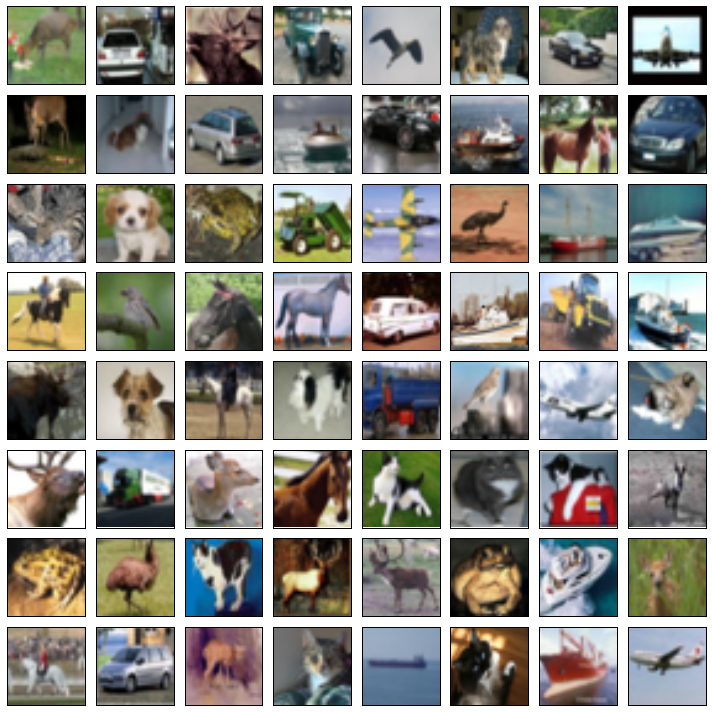

In [5]:
# VISUALIZE IMAGES
def plotImages( images, n_images=8):
    fig, axes = plt.subplots(n_images, n_images, figsize=(10, 10))
    axes = axes.flatten()
    for img, ax in zip(images, axes):
        ax.imshow(img)
        ax.set_xticks(())
        ax.set_yticks(())
    plt.tight_layout()
    plt.show()
    
plotImages(X_train)

In [6]:
# convert labels to categorical
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)
Y_val = np_utils.to_categorical(y_val, nb_classes)

print('label integer encoded: y_train[0]: ', y_train[0])
print('label one-hot encoded: Y_train[0]: ', Y_train[0])


('label integer encoded: y_train[0]: ', array([4], dtype=uint8))
('label one-hot encoded: Y_train[0]: ', array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.], dtype=float32))


## CNN Model - AlexNet 

**Task**: Implement an AlexNet like CNN as visualized in the Figure below. 

* Use strides=(1,1) for all convolutional layers. 
* Use 'relu' as activation for both, conv and dense (fully connected) layers. 
* Spatial extent is reduced by using maxpooling. Set the pool_size0(3,3) and set the parameter strides, such that the spatial extent is reduced by factor 2 in both spatial dimensions.
* For both dense layers use 128 neurons instead of 4096 to reduce the number of parameters for this tutorial.
* Add dropout layers after the first and second convolutional layer as well as after both dense layers. Use the given dropout probabilities `prob_drop_conv = 0.2` and `prob_drop_hidden = 0.5`.

**Questions to answer**:

1. How does the Total number of trainable parameters change, when we change the number of neurons in the first dense layer from 128 to the original proposed 4096?
2. AlexNet was designed for ImageNet input images with a size of 224x224 pixels. Concerning the first convolutional layer, what could we change to adapt better to our dataset?

![title](figures/alexnet.png)
*Figure 1: Visualization of the AlexNet(-like) architecture for the ImageNet challenge (1000 classes)*


img source: http://cv-tricks.com/wp-content/uploads/2017/03/xalexnet_small-1.png.pagespeed.ic.q5Lnn1-u6h.png



In [7]:
# parameters:
base_learning_rate = 0.0001
batch_size = 128

pool_size = (3, 3)                  # size of pooling area for max pooling
prob_drop_conv = 0.2                # drop probability for dropout @ conv layer
prob_drop_hidden = 0.5              # drop probability for dropout @ fc layer

def AlexNet():

    model = Sequential()

    # conv1 layer
    conv1 = Conv2D(filters=96, kernel_size=(11, 11), strides=(1,1), padding='same', activation='relu', 
                   input_shape=input_shape)
    model.add(conv1)
    model.add(MaxPooling2D(pool_size=(pool_size), strides=(2, 2), padding='same'))
    model.add(Dropout(prob_drop_conv))

    # conv2 layer
    model.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1,1), padding='same', activation='relu' ))
    model.add(MaxPooling2D(pool_size=pool_size, strides=(2,2), padding='same'))
    model.add(Dropout(prob_drop_conv))

    # conv3 layer
    model.add(Conv2D(filters=384, kernel_size=(3, 3), padding='same', activation='relu'))
    
    # conv4 layer
    model.add(Conv2D(filters=384, kernel_size=(3, 3), padding='same', activation='relu'))

    # conv5 layer
    model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=pool_size, strides=(2,2), padding='same'))

    
    model.add(Flatten())

    # fc1 layer
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(prob_drop_hidden))

    # fc2 layer
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(prob_drop_hidden))

    # fc3 layer
    model.add(Dense(nb_classes, activation='softmax'))

    return model


model_alexNet = AlexNet()
model_alexNet.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 96)        34944     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 96)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 256)       614656    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 384)         885120    
__________

In [8]:
# Calculate the number of batches per epoch. 
# One epoch is defined as an update pass through the full training data. 
# One iteration is defined as an update through one mini-batch.
batches_per_epoch = X_train.shape[0]//batch_size
# the number of batches to see the full validation data:
validation_steps = X_val.shape[0]//batch_size
print('number of images per batch: {}'.format(batch_size))
print('batches per epoch: {}'.format(batches_per_epoch))
print('validation steps: {}'.format(validation_steps))

number of images per batch: 128
batches per epoch: 312
validation steps: 78


In [9]:
# Data generator to load the training data as batches

def generator(features, labels, batch_size, patch_size, channels, nb_classes):
 # Create empty arrays to contain batch of features and labels#
 batch_features = np.zeros((batch_size, patch_size, patch_size, channels))
 batch_labels = np.zeros((batch_size, nb_classes))

 while True:
    for i in range(batch_size):
         # choose random index in features
         index = np.random.choice(a=features.shape[0], size=1)

         #TODO add some data augmentation here

         batch_features[i] = features[index, :, :, :]
         batch_labels[i] = labels[index]
    yield batch_features, batch_labels

In [10]:
# Function to re-initialize the weights before starting a new experiment/training

def initialize_weights(model, layer_name=None):
    session = K.get_session()
    if layer_name is None:
        for layer in model.layers: 
            if hasattr(layer, 'kernel_initializer'):
                print('initialize weights of layer: {}'.format(layer.name))
                layer.kernel.initializer.run(session=session)
    else:
        layer = model.get_layer(name=layer_name)
        if hasattr(layer, 'kernel_initializer'):
            print('initialize weights of layer: {}'.format(layer.name))
            layer.kernel.initializer.run(session=session)
                    

In [11]:
# Helper function to plot training curves

def plot_train_val_accuracy_and_loss(history, legend_suffix=""):
    # list all data in history
    print(history.history.keys())

    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_'+legend_suffix, 'val_'+legend_suffix], loc='lower right')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_'+legend_suffix, 'val_'+legend_suffix], loc='upper right')
    plt.show()

## Train the model on original data

We stop training after 3 epochs... 

* Did the model learn anything yet? Is it better than a random classifier?

initialize weights of layer: conv2d_6
initialize weights of layer: conv2d_7
initialize weights of layer: conv2d_8
initialize weights of layer: conv2d_9
initialize weights of layer: conv2d_10
initialize weights of layer: dense_4
initialize weights of layer: dense_5
initialize weights of layer: dense_6
Epoch 1/4
312/312 [==============================] - 10s 31ms/step - loss: 2.5140 - acc: 0.1005 - val_loss: 2.3026 - val_acc: 0.1076
Epoch 2/4
312/312 [==============================] - 9s 28ms/step - loss: 2.3026 - acc: 0.1001 - val_loss: 2.3026 - val_acc: 0.0965
Epoch 3/4
312/312 [==============================] - 9s 28ms/step - loss: 2.3026 - acc: 0.0996 - val_loss: 2.3027 - val_acc: 0.0972
Epoch 4/4
312/312 [==============================] - 9s 28ms/step - loss: 2.3026 - acc: 0.1013 - val_loss: 2.3026 - val_acc: 0.0975
['acc', 'loss', 'val_acc', 'val_loss']


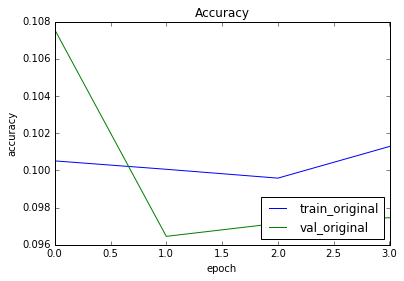

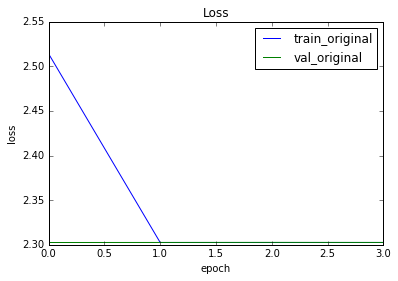

In [12]:
nb_epoch = 4 # 4
model=AlexNet()
opt = Adam(lr=base_learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# re-initialize weights of the model before training again
initialize_weights(model)

history_original = model.fit_generator(
        generator(features=X_train, labels=Y_train, batch_size=batch_size, patch_size=img_cols, channels=channels, 
                  nb_classes=nb_classes),
        steps_per_epoch=batches_per_epoch, epochs=nb_epoch, 
        validation_data=generator(features=X_val, labels=Y_val, batch_size=batch_size, patch_size=img_cols, 
                                  channels=channels, nb_classes=nb_classes),
        validation_steps=validation_steps)

plot_train_val_accuracy_and_loss(history_original, legend_suffix='original')


In [13]:
# Evaluate the model trained on the original data
evaluation = model.evaluate(X_test, Y_test, batch_size=256, verbose=1)
print('Summary: Loss over the test dataset: %.2f, Accuracy: %.2f' % (evaluation[0], evaluation[1]))

10000/10000 [==============================] - 1s 90us/step
Summary: Loss over the test dataset: 2.30, Accuracy: 0.10


## Preprocess the input images

We subtract the training mean and divide by the training standard deviation for each RGB channel separately.

In [14]:
# PREPROCESSING: NORMALIZE THE INPUT DATA
# as calculating the Mean and STD over the entire training data takes some time, the values are provide.

def get_mean_and_std_per_channel(data_train, patch_size, channels=3):
    N = data_train.shape[0]
    img_concat = None
    for i in range(data_train.shape[0]):
        img = data_train[i, :, :, :]
        print(i)
        assert len(img.shape) == 3

        if img_concat is None:
            img_concat = img
        else:
            img_concat = np.concatenate((img_concat, img), axis=0)

    assert img_concat.shape == (N * patch_size, patch_size, channels)
    print('img_concat.shape', img_concat.shape)

    # calculate mean
    mean = np.mean(img_concat, axis=(0, 1))
    mean = mean.reshape(1, 1, channels)
    print('mean: ', mean)
    print('mean.shape', mean.shape)
    assert mean.shape == (1, 1, channels)

    # control mean
    img_concat_zero_mean = img_concat - np.tile(mean, [N * patch_size, patch_size, 1])
    mean_control = np.mean(img_concat_zero_mean, axis=(0, 1))
    print('mean_control', mean_control)

    # calculate std
    std = np.std(img_concat_zero_mean, axis=(0, 1))
    std = std.reshape(1, 1, channels)
    print('std: ', std)
    print('std.shape', std.shape)
    assert std.shape == (1, 1, channels)

    # control std
    img_concat_zero_mean_std_1 = np.divide(img_concat_zero_mean, np.tile(std, [N * patch_size, patch_size, 1]))
    std_control = np.std(img_concat_zero_mean_std_1, axis=(0, 1))
    print('std_control: ', std_control)
    return mean, std

def normalize_img_per_channel(image, mean_train, std_train, patch_size):
    img_zero_mean = image - np.tile(mean_train, [patch_size, patch_size, 1])
    img_norm = np.divide(img_zero_mean, np.tile(std_train, [patch_size, patch_size, 1]))
    return img_norm

def normalize_images_per_channel(images, mean_train, std_train, out_dtype='float32'):
    images_norm = []
    for i in range(images.shape[0]):
        img = images[i, :, :, :]
        assert len(img.shape) == 3
        img_norm = normalize_img_per_channel(img, mean_train, std_train, patch_size=img.shape[0])
        images_norm.append(img_norm)
    return np.asarray(images_norm, out_dtype)

# print('calculating mean and std per channel from the training data...')
# mean_train_file = data_dir + '/cifar10_mean_train.npy'
# std_train_file = data_dir + '/cifar10_std_train.npy'
# MEAN_train, STD_train = get_mean_and_std_per_channel(data_train=X_train, patch_size=img_cols, channels=channels)
# np.save(mean_train_file, MEAN_train)
# np.save(std_train_file, STD_train)
# #load mean, std from file
# MEAN_train = np.load(mean_train_file)
# STD_train = np.load(std_train_file)

# Cifar10 mean and std from training data
MEAN_train = [[[125.30691805, 122.95039414, 113.86538318]]]
STD_train = [[[62.99321928, 62.08870764, 66.70489964]]]

X_train_prepro = normalize_images_per_channel(images=X_train, mean_train=MEAN_train, std_train=STD_train, 
                                              out_dtype='float32')
X_test_prepro = normalize_images_per_channel(images=X_test, mean_train=MEAN_train, std_train=STD_train, 
                                             out_dtype='float32')
X_val_prepro = normalize_images_per_channel(images=X_val, mean_train=MEAN_train, std_train=STD_train, 
                                            out_dtype='float32')


## Train the model on preprocessed images

* What is the purpose of preprocessing the input data?

initialize weights of layer: conv2d_11
initialize weights of layer: conv2d_12
initialize weights of layer: conv2d_13
initialize weights of layer: conv2d_14
initialize weights of layer: conv2d_15
initialize weights of layer: dense_7
initialize weights of layer: dense_8
initialize weights of layer: dense_9
Epoch 1/12
312/312 [==============================] - 9s 29ms/step - loss: 2.1064 - acc: 0.2162 - val_loss: 1.7795 - val_acc: 0.3709
Epoch 2/12
312/312 [==============================] - 9s 29ms/step - loss: 1.7897 - acc: 0.3515 - val_loss: 1.5321 - val_acc: 0.4685
Epoch 3/12
312/312 [==============================] - 9s 30ms/step - loss: 1.5703 - acc: 0.4414 - val_loss: 1.3982 - val_acc: 0.5210
Epoch 4/12
312/312 [==============================] - 9s 29ms/step - loss: 1.3955 - acc: 0.5086 - val_loss: 1.3059 - val_acc: 0.5571
Epoch 5/12
312/312 [==============================] - 9s 30ms/step - loss: 1.3045 - acc: 0.5499 - val_loss: 1.2068 - val_acc: 0.6046
Epoch 6/12
312/312 [=========

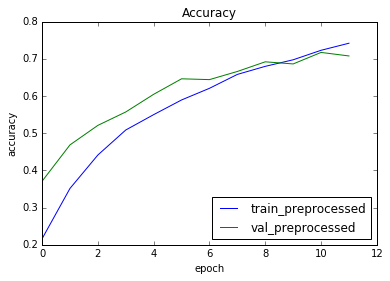

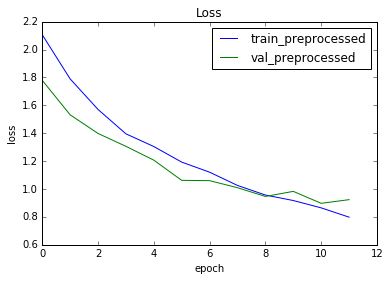

In [15]:
# Train the model again with preprocessed images

nb_epoch = 12 # 12

model=AlexNet()
opt = Adam(lr=base_learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# re-initialize the weights of the model to train again from scratch
initialize_weights(model)

history_preprocessed = model.fit_generator(
        generator=generator(features=X_train_prepro, labels=Y_train, batch_size=batch_size, patch_size=img_cols, 
                            channels=channels, nb_classes=nb_classes),
        steps_per_epoch=batches_per_epoch, epochs=nb_epoch, 
        validation_data=generator(features=X_val_prepro, labels=Y_val, batch_size=batch_size, patch_size=img_cols, 
                                  channels=channels, nb_classes=nb_classes),
        validation_steps=validation_steps)

plot_train_val_accuracy_and_loss(history_preprocessed, legend_suffix='preprocessed')


In [16]:
# Evaluate the model trained on preprocessed input data
evaluation = model.evaluate(X_test_prepro, Y_test, batch_size=256, verbose=1)
print('Summary: Loss over the test dataset: %.2f, Accuracy: %.2f' % (evaluation[0], evaluation[1]))

10000/10000 [==============================] - 1s 68us/step
Summary: Loss over the test dataset: 0.83, Accuracy: 0.73


## Extend the AlexNet like architecture
Copy the AlexNet architecture from above into the template AlexNet_modified() and modify/extend it to improve the performance. 

Possible modifications:    
    * higher model capacity
    * stronger non-linearity (increase model depth/ # layers)
    * stronger pooling (shrinkage -> global information)
    * stronger regularization (dropout)
    
Tipp: Try to build a deeper model without increasing the number of parameters too much.

* Compare the number of parameters to the previous model. Which layers introduce most of the parameters?

In [17]:
# One possible solution
base_learning_rate = 0.0001
batch_size = 128

pool_size = (3, 3)                  # size of pooling area for max pooling
prob_drop_conv = 0.2                # drop probability for dropout @ conv layer
prob_drop_hidden = 0.5              # drop probability for dropout @ fc layer

def AlexNet_modified():

    model = Sequential()

    # conv1 layer
    conv1 = Conv2D(filters=96, kernel_size=(3, 3), strides=(1,1), padding='same', activation='relu', 
                   input_shape=input_shape)
    model.add(conv1)

    # conv1.1 layer
    model.add(Conv2D(filters=96, kernel_size=(3, 3), strides=(1,1), padding='same', activation='relu', 
                   input_shape=input_shape))
        
    model.add(MaxPooling2D(pool_size=(pool_size), strides=(2, 2), padding='same'))
    model.add(Dropout(prob_drop_conv))

    # conv2 layer
    model.add(Conv2D(filters=256, kernel_size=(3, 3), strides=(1,1), padding='same', activation='relu' ))
    
    # conv2.1 layer
    model.add(Conv2D(filters=256, kernel_size=(3, 3), strides=(1,1), padding='same', activation='relu' ))
    
    model.add(MaxPooling2D(pool_size=pool_size, strides=(2,2), padding='same'))
    model.add(Dropout(prob_drop_conv))

    # conv3 layer
    model.add(Conv2D(filters=384, kernel_size=(3, 3), padding='same', activation='relu'))
    
    # conv4 layer
    model.add(Conv2D(filters=384, kernel_size=(3, 3), padding='same', activation='relu'))

    # conv4.1 layer
    model.add(Conv2D(filters=384, kernel_size=(3, 3), padding='same', activation='relu'))
    
    # conv4.2 layer
    model.add(Conv2D(filters=384, kernel_size=(3, 3), padding='same', activation='relu'))
    
    # conv5 layer
    model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=pool_size, strides=(2,2), padding='same'))

    
    model.add(Flatten())
    model.add(Dropout(prob_drop_conv))

    # fc1 layer
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(prob_drop_hidden))

    # fc2 layer
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(prob_drop_hidden))

    # fc3 layer
    model.add(Dense(nb_classes, activation='softmax'))
    
    return model

    
model_alexNet_mod = AlexNet_modified()
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 32, 32, 96)        34944     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 96)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 16, 16, 96)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 16, 256)       614656    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 8, 8, 384)         885120    
__________

## Train the modified AlexNet on preprocessed data

* Could you improve the performance?
* What changed concerning the convergence time?

initialize weights of layer: conv2d_25
initialize weights of layer: conv2d_26
initialize weights of layer: conv2d_27
initialize weights of layer: conv2d_28
initialize weights of layer: conv2d_29
initialize weights of layer: conv2d_30
initialize weights of layer: conv2d_31
initialize weights of layer: conv2d_32
initialize weights of layer: conv2d_33
initialize weights of layer: dense_13
initialize weights of layer: dense_14
initialize weights of layer: dense_15
Epoch 1/12
312/312 [==============================] - 16s 52ms/step - loss: 2.0875 - acc: 0.2025 - val_loss: 1.7731 - val_acc: 0.3329
Epoch 2/12
312/312 [==============================] - 15s 49ms/step - loss: 1.7493 - acc: 0.3365 - val_loss: 1.4843 - val_acc: 0.4685
Epoch 3/12
312/312 [==============================] - 16s 50ms/step - loss: 1.5529 - acc: 0.4286 - val_loss: 1.2874 - val_acc: 0.5410
Epoch 4/12
312/312 [==============================] - 15s 49ms/step - loss: 1.3385 - acc: 0.5291 - val_loss: 1.1331 - val_acc: 0.5983

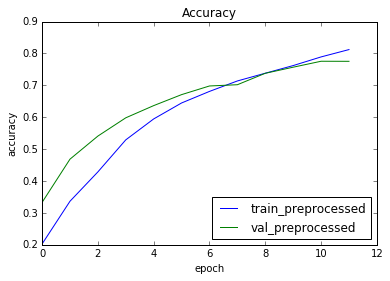

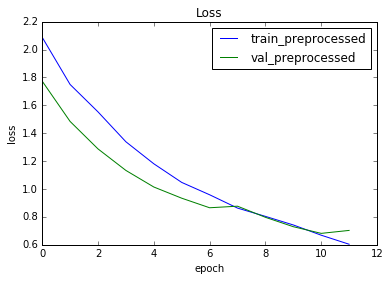

In [18]:
# TRAIN the model again
# NEW: PREPROCESSED INPUT IMAGES

nb_epoch = 12 # 12

model = AlexNet_modified()
opt = Adam(lr=base_learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# re-initialize the weights of the model to train again from scratch
initialize_weights(model)

history_preprocessed = model.fit_generator(
        generator=generator(features=X_train_prepro, labels=Y_train, batch_size=batch_size, patch_size=img_cols, 
                            channels=channels, nb_classes=nb_classes),
        steps_per_epoch=batches_per_epoch, epochs=nb_epoch, 
        validation_data=generator(features=X_val_prepro, labels=Y_val, batch_size=batch_size, patch_size=img_cols, 
                                  channels=channels, nb_classes=nb_classes),
        validation_steps=validation_steps)

plot_train_val_accuracy_and_loss(history_preprocessed, legend_suffix='preprocessed')


In [19]:
# Evaluate the model trained on preprocessed input data
evaluation = model.evaluate(X_test_prepro, Y_test, batch_size=256, verbose=1)
print('Summary: Loss over the test dataset: %.2f, Accuracy: %.2f' % (evaluation[0], evaluation[1]))

10000/10000 [==============================] - 1s 129us/step
Summary: Loss over the test dataset: 0.67, Accuracy: 0.79


## Data augmentation: Train the modified AlexNet using data augmentation

A common trick to improve performance is to use data augmentation at train time. Let's try:

The keras ImageDataGenerator provides an image generator with built in data augmentation: https://keras.io/preprocessing/image/

Set meaningful data augmentation parameters.

* Could you improve the performance?
* What changed concerning the convergence time?

initialize weights of layer: conv2d_34
initialize weights of layer: conv2d_35
initialize weights of layer: conv2d_36
initialize weights of layer: conv2d_37
initialize weights of layer: conv2d_38
initialize weights of layer: conv2d_39
initialize weights of layer: conv2d_40
initialize weights of layer: conv2d_41
initialize weights of layer: conv2d_42
initialize weights of layer: dense_16
initialize weights of layer: dense_17
initialize weights of layer: dense_18
Epoch 1/24
312/312 [==============================] - 16s 53ms/step - loss: 2.1182 - acc: 0.1944 - val_loss: 1.7580 - val_acc: 0.3443
Epoch 2/24
312/312 [==============================] - 16s 51ms/step - loss: 1.8094 - acc: 0.3125 - val_loss: 1.5469 - val_acc: 0.4378
Epoch 3/24
312/312 [==============================] - 15s 49ms/step - loss: 1.5588 - acc: 0.4227 - val_loss: 1.2686 - val_acc: 0.5500
Epoch 4/24
312/312 [==============================] - 15s 50ms/step - loss: 1.3822 - acc: 0.5066 - val_loss: 1.1202 - val_acc: 0.6078

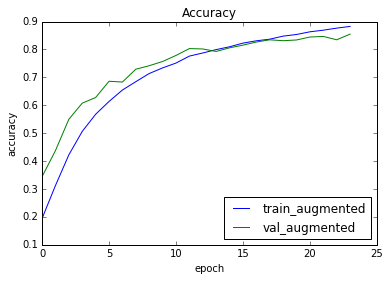

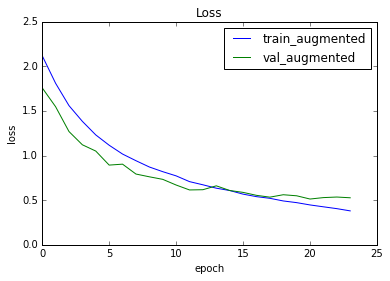

In [20]:
# TRAIN the model again with data augmentation

nb_epoch = 24 # 26

model = AlexNet_modified()
opt = Adam(lr=base_learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# TODO
# image generator for data augmentation. Documentation: https://keras.io/preprocessing/image/
image_gen = ImageDataGenerator(
    width_shift_range=5,   # pixel
    height_shift_range=5,  # pixel
    horizontal_flip=True)

# re-initialize weights of the model before training again
initialize_weights(model)

history_augmented = model.fit_generator(
        generator=image_gen.flow(X_train_prepro, Y_train, batch_size=batch_size),
        steps_per_epoch=batches_per_epoch,
        epochs=nb_epoch,
        verbose=1,
        shuffle=True,
        validation_data=generator(features=X_val_prepro, labels=Y_val, batch_size=batch_size, patch_size=img_cols, 
                                  channels=channels, nb_classes=nb_classes),
        validation_steps=validation_steps)

plot_train_val_accuracy_and_loss(history_augmented, legend_suffix='augmented')


In [21]:
# Evaluate the model trained with augmented training data
evaluation = model.evaluate(X_test_prepro, Y_test, batch_size=256, verbose=1)
print('Summary: Loss over the test dataset: %.2f, Accuracy: %.2f' % (evaluation[0], evaluation[1]))

10000/10000 [==============================] - 1s 116us/step
Summary: Loss over the test dataset: 0.50, Accuracy: 0.85


## Compare the performance w/ and w/o data augmentation

Did the data augmentation improve performance? Can you explain why?


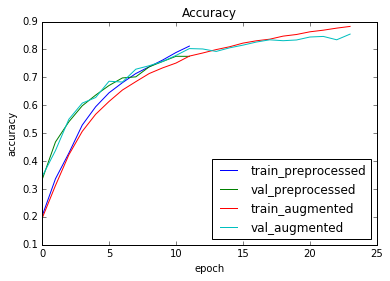

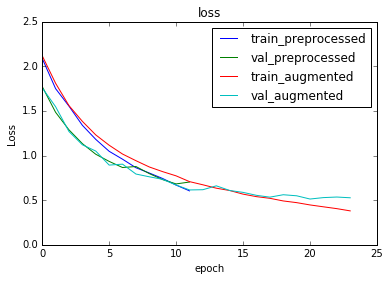

In [22]:
# collect all histories and plot all curves in same figure
# comment: we skipt the result on the original data, as the model performance was poor

history_list = [history_preprocessed, history_augmented]
legend_suffix_list = ['preprocessed', 'augmented']

# plot accuracy curves
acc_legend = []
for history, legend_suffix in zip(history_list, legend_suffix_list):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    acc_legend += ['train_'+legend_suffix, 'val_'+legend_suffix]
plt.legend(acc_legend, loc='lower right')
plt.show()

# plot loss curves
loss_legend = []
for history, legend_suffix in zip(history_list, legend_suffix_list):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('loss')
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    loss_legend += ['train_'+legend_suffix, 'val_'+legend_suffix]
plt.legend(loss_legend, loc='upper right')
plt.show()

## ResNet50

As we are working with small input images (32x32 pixels) this version of the ResNet50 has modified strides, such that the spatial extent of the feature maps is not reduced too much.

code source: https://github.com/flyyufelix/cnn_finetune

In [40]:
from keras.models import Sequential
from keras.optimizers import SGD
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, Dropout, Flatten, merge, Reshape, Activation
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras import backend as K

def identity_block(input_tensor, kernel_size, filters, stage, block):
    """
    The identity_block is the block that has no conv layer at shortcut
    Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at main path
        filters: list of integers, the nb_filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    """

    nb_filter1, nb_filter2, nb_filter3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters=nb_filter1, kernel_size=(1, 1), name=conv_name_base + '2a')(input_tensor)

    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=nb_filter2, kernel_size=(kernel_size, kernel_size), 
               padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=nb_filter3, kernel_size=(1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = merge([x, input_tensor], mode='sum')
    x = Activation('relu')(x)
    return x


def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
    """
    conv_block is the block that has a conv layer at shortcut
    # Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at main path
        filters: list of integers, the nb_filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    Note that from stage 3, the first conv layer at main path is with subsample=(2,2)
    And the shortcut should have subsample=(2,2) as well
    """

    nb_filter1, nb_filter2, nb_filter3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters=nb_filter1, kernel_size=(1, 1), strides=strides,
                      name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=nb_filter2, kernel_size= (kernel_size, kernel_size), padding='same',
                      name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=nb_filter3, kernel_size=(1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = Conv2D(filters=nb_filter3, kernel_size=(1, 1), strides=strides,
                             name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = merge([x, shortcut], mode='sum')
    x = Activation('relu')(x)
    return x



def ResNet50(img_input):
    model = Sequential()

    x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2), name='conv1', padding='same')(img_input)
    x = BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)


    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')
    
    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a', strides=(1, 1))
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')
    
    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a', strides=(1, 1))
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a', strides=(1, 1))
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')

    # Fully Connected Softmax Layer
    x_fc = AveragePooling2D((3, 3), name='avg_pool')(x)
    x_fc = Flatten()(x_fc)
    x_fc = Dense(nb_classes, activation='softmax', name='cifar10_logits')(x_fc)

    model = Model(img_input, x_fc)
    model.summary()
    return model


if K.image_dim_ordering() == 'tf':
  bn_axis = 3
  img_input = Input(shape=(img_rows, img_cols, channels))
else:
  bn_axis = 1
  img_input = Input(shape=(color_type, img_rows, channels))

my_model = ResNet50(img_input)



/home/nlang/.local/lib/python2.7/site-packages/ipykernel_launcher.py:75: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/nlang/.local/lib/python2.7/site-packages/ipykernel_launcher.py:36: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   9472        input_3[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 16, 16, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_99 (Activation)      (None, 16, 16, 64)   0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

### Transfer learning: Initialize the model with pre-trained weights from a model trained on ImageNet dataset
ImageNet: http://image-net.org/about-overview

ResNet50 weights pre-trained on ImageNet can be downloaded here: https://github.com/flyyufelix/cnn_finetune

Save the weights file (.h5) in the following directory: pretrained_models_imageNet (or change the `weights_path` accordingly)

We initialize the layer weights from the pre-trained model by layer name. In the final dense layer, we set the number of classes to 10 to solve our cifar10 task. Therefore, the number of parameters has changed compared to the pre-trained model with 1000 classes from another task. By changing the layer name to 'cifar10_logits', the final layer is not initialized from the pre-trained model, but with random weights.

In [41]:
base_learning_rate = 0.001
opt = Adam(lr=base_learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

weights_path='pretrained_models_imageNet/resnet50_weights_tf_dim_ordering_tf_kernels.h5'

my_model.load_weights(filepath=weights_path, by_name=True, skip_mismatch=True)

### Fix all layers except the final dense layer (and batch_norm layers)

For the final dense layer, we do not have a good initialization yet. This layer will be initialized randomly. If we would train the new final layer as well as all ohter layers with good initialization together, the random weights from the new layer could deteriorate the already good featrues from our pre-trained model. One way to avoid this, is to fix all layer weights during the training and update only the weights for the last dense layer. Once we have a decent classifier, we allow also all other weights to update.

In [42]:
# train only the final dense layer and keep all other layers fixed (except the batch_norm)
print('total number of layers:', len(my_model.layers))
for layer in my_model.layers[:-1]:
    if not 'bn' in layer.name: # we need to update the batch_norm layers anyways
        print(layer.name)
        layer.trainable = False # can be set to False to fix the weights during training

my_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

('total number of layers:', 176)
input_3
conv1
activation_99
max_pooling2d_21
res2a_branch2a
activation_100
res2a_branch2b
activation_101
res2a_branch2c
res2a_branch1
merge_33
activation_102
res2b_branch2a
activation_103
res2b_branch2b
activation_104
res2b_branch2c
merge_34
activation_105
res2c_branch2a
activation_106
res2c_branch2b
activation_107
res2c_branch2c
merge_35
activation_108
res3a_branch2a
activation_109
res3a_branch2b
activation_110
res3a_branch2c
res3a_branch1
merge_36
activation_111
res3b_branch2a
activation_112
res3b_branch2b
activation_113
res3b_branch2c
merge_37
activation_114
res3c_branch2a
activation_115
res3c_branch2b
activation_116
res3c_branch2c
merge_38
activation_117
res3d_branch2a
activation_118
res3d_branch2b
activation_119
res3d_branch2c
merge_39
activation_120
res4a_branch2a
activation_121
res4a_branch2b
activation_122
res4a_branch2c
res4a_branch1
merge_40
activation_123
res4b_branch2a
activation_124
res4b_branch2b
activation_125
res4b_branch2c
merge_41
acti

initialize weights of layer: cifar10_logits


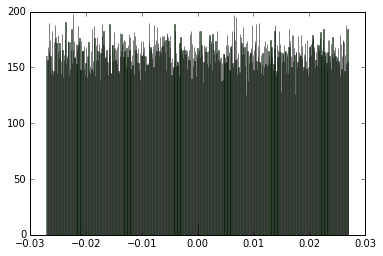

In [43]:
# plot the weights of the final dense layer (before training)
initialize_weights(my_model, layer_name='cifar10_logits')
w = my_model.get_layer(name='cifar10_logits').get_weights()
plt.figure()
n, bins, patches = plt.hist(w, bins=501, facecolor='green', alpha=0.5)

## Train the ResNet50 model with data augmentation

Epoch 1/4
312/312 [==============================] - 41s 132ms/step - loss: 1.2968 - acc: 0.6063 - val_loss: 1.0854 - val_acc: 0.6848
Epoch 2/4
312/312 [==============================] - 39s 124ms/step - loss: 0.8845 - acc: 0.7092 - val_loss: 1.0229 - val_acc: 0.7121
Epoch 3/4
312/312 [==============================] - 39s 124ms/step - loss: 0.7326 - acc: 0.7526 - val_loss: 1.0269 - val_acc: 0.7351
Epoch 4/4
312/312 [==============================] - 39s 125ms/step - loss: 0.6459 - acc: 0.7771 - val_loss: 1.0276 - val_acc: 0.7334
['acc', 'loss', 'val_acc', 'val_loss']


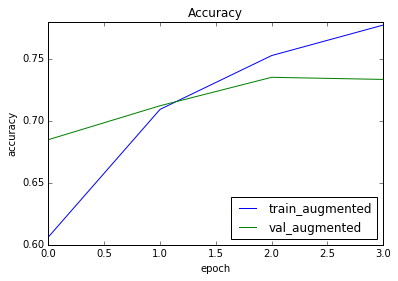

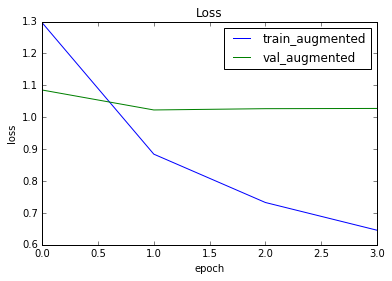

In [44]:
# image generator for data augmentation. Documentation: https://keras.io/preprocessing/image/
image_gen = ImageDataGenerator(
    width_shift_range=5,   # pixel
    height_shift_range=5,  # pixel
    horizontal_flip=True)


nb_epoch = 4 # 26

history_augmented = my_model.fit_generator(
        generator=image_gen.flow(X_train_prepro, Y_train, batch_size=batch_size),
        steps_per_epoch=batches_per_epoch,
        epochs=nb_epoch,
        verbose=1,
        shuffle=True,
        validation_data=generator(features=X_val_prepro, labels=Y_val, batch_size=batch_size, patch_size=img_cols, 
                                  channels=channels, nb_classes=nb_classes),
        validation_steps=validation_steps)

plot_train_val_accuracy_and_loss(history_augmented, legend_suffix='augmented')

In [45]:
# Evaluate the model trained with augmented training data
evaluation = my_model.evaluate(X_test_prepro, Y_test, batch_size=256, verbose=1)
print('Summary: Loss over the test dataset: %.2f, Accuracy: %.2f' % (evaluation[0], evaluation[1]))

10000/10000 [==============================] - 4s 433us/step
Summary: Loss over the test dataset: 0.70, Accuracy: 0.77


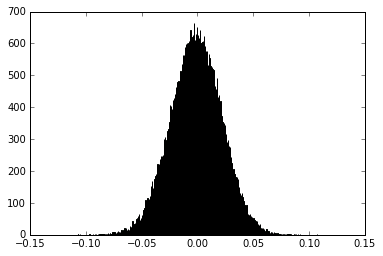

In [46]:
# plot the learned weights of the final dense layer (after training)
w = my_model.get_layer(name='cifar10_logits').get_weights()
plt.figure()
n, bins, patches = plt.hist(w, bins=500, facecolor='green', alpha=1)

### Allow all layers to update the weights during training

('total number of layers:', 176)
input_3
conv1
bn_conv1
activation_99
max_pooling2d_21
res2a_branch2a
bn2a_branch2a
activation_100
res2a_branch2b
bn2a_branch2b
activation_101
res2a_branch2c
res2a_branch1
bn2a_branch2c
bn2a_branch1
merge_33
activation_102
res2b_branch2a
bn2b_branch2a
activation_103
res2b_branch2b
bn2b_branch2b
activation_104
res2b_branch2c
bn2b_branch2c
merge_34
activation_105
res2c_branch2a
bn2c_branch2a
activation_106
res2c_branch2b
bn2c_branch2b
activation_107
res2c_branch2c
bn2c_branch2c
merge_35
activation_108
res3a_branch2a
bn3a_branch2a
activation_109
res3a_branch2b
bn3a_branch2b
activation_110
res3a_branch2c
res3a_branch1
bn3a_branch2c
bn3a_branch1
merge_36
activation_111
res3b_branch2a
bn3b_branch2a
activation_112
res3b_branch2b
bn3b_branch2b
activation_113
res3b_branch2c
bn3b_branch2c
merge_37
activation_114
res3c_branch2a
bn3c_branch2a
activation_115
res3c_branch2b
bn3c_branch2b
activation_116
res3c_branch2c
bn3c_branch2c
merge_38
activation_117
res3d_branch2

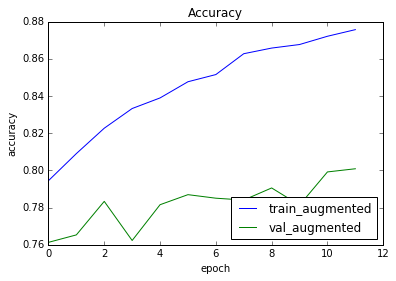

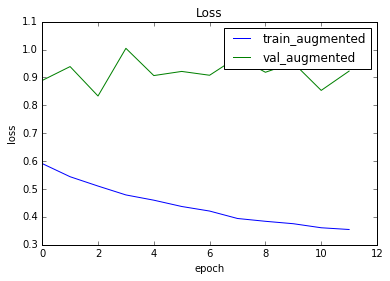

In [47]:
# train all the other layers as well
print('total number of layers:', len(my_model.layers))
for layer in my_model.layers[:]:
    print(layer.name)
    layer.trainable = True # can be set to False to fix the weights during training
    
nb_epoch = 12     
    
history_augmented = my_model.fit_generator(
        generator=image_gen.flow(X_train_prepro, Y_train, batch_size=batch_size),
        steps_per_epoch=batches_per_epoch,
        epochs=nb_epoch,
        verbose=1,
        shuffle=True,
        validation_data=generator(features=X_val_prepro, labels=Y_val, batch_size=batch_size, patch_size=img_cols, 
                                  channels=channels, nb_classes=nb_classes),
        validation_steps=validation_steps)

plot_train_val_accuracy_and_loss(history_augmented, legend_suffix='augmented')

In [48]:
# Evaluate the model trained with augmented training data
evaluation = my_model.evaluate(X_test_prepro, Y_test, batch_size=256, verbose=1)
print('Summary: Loss over the test dataset: %.2f, Accuracy: %.2f' % (evaluation[0], evaluation[1]))

10000/10000 [==============================] - 4s 431us/step
Summary: Loss over the test dataset: 0.53, Accuracy: 0.83


## Keras already provides many CNN architectures including pre-trained weights

For an easy start, check out: https://keras.io/applications/